In [1]:
colors = ['#576fa0', '#b57979', '#e3b87f']

<ipython-input-4-42b584dddebc>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


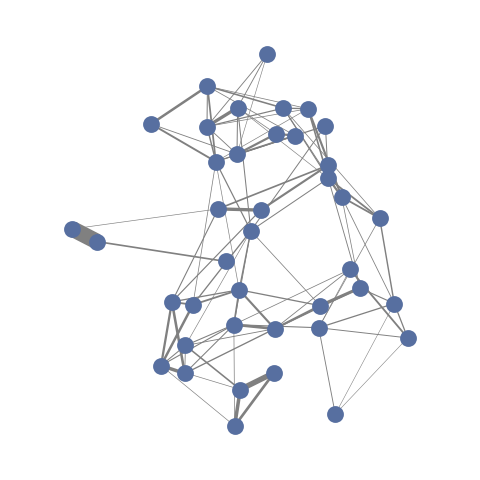

In [4]:
import MDAnalysis as mda
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

u = mda.Universe("./CAHS12/sim_3/protein_shifted.pdb", "./CAHS12/sim_3/protein.xtc")
proteins = [seg.atoms for seg in u.segments]

cutoff = 0.4

u.trajectory[-1]

G = nx.Graph()

for i in range(len(proteins)):
    G.add_node(i)

for i in range(len(proteins)):
    for j in range(i + 1, len(proteins)):
        pos_i = proteins[i].positions
        pos_j = proteins[j].positions
        
        dist_matrix = cdist(pos_i, pos_j)
        if np.any(dist_matrix < cutoff * 10):  # cutoff in Å
            com_i = proteins[i].center_of_mass()
            com_j = proteins[j].center_of_mass()
            com_dist = np.linalg.norm(com_i - com_j)
            weight = 1.0 / com_dist if com_dist != 0 else 0.0
            G.add_edge(i, j, weight=weight)


weights = [G[u][v]['weight'] * 50 for u, v in G.edges()]  # scaled for better visibility
positions = nx.spring_layout(G, seed=100)


plt.figure(figsize=(3, 3), dpi=150)
nx.draw(
    G, positions,
    with_labels=False,
    node_color='#576fa0',
    edge_color='gray',
    width=weights,
    node_size=50
)
plt.axis("equal")
plt.tight_layout()
plt.savefig('net-full.pdf', format='pdf', dpi=400, transparent=True, bbox_inches='tight')

plt.show()

<ipython-input-5-edf65a3541f9>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


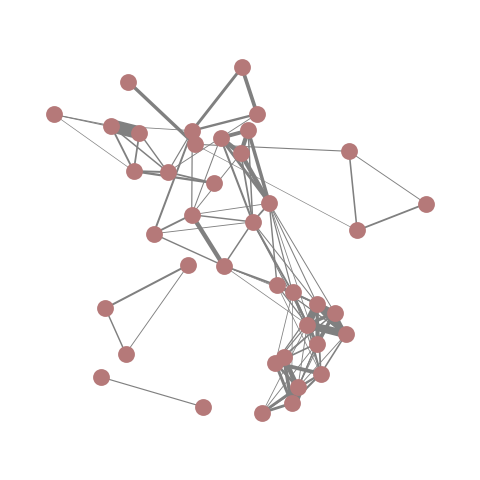

In [5]:
import MDAnalysis as mda
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

u = mda.Universe("./CAHS12-dC/sim_2/protein_shifted.pdb", "./CAHS12-dC/sim_2/protein.xtc")

proteins = [seg.atoms for seg in u.segments]

cutoff = 0.4  # 0.4 nm = 4 Å

u.trajectory[-1]

G = nx.Graph()

for i in range(len(proteins)):
    G.add_node(i)

for i in range(len(proteins)):
    for j in range(i + 1, len(proteins)):
        pos_i = proteins[i].positions
        pos_j = proteins[j].positions
        
        dist_matrix = cdist(pos_i, pos_j)
        if np.any(dist_matrix < cutoff * 10):  # cutoff in Å
            com_i = proteins[i].center_of_mass()
            com_j = proteins[j].center_of_mass()
            com_dist = np.linalg.norm(com_i - com_j)
            weight = 1.0 / com_dist if com_dist != 0 else 0.0
            G.add_edge(i, j, weight=weight)

positions = nx.spring_layout(G, seed=100)
weights = [G[u][v]['weight'] * 50 for u, v in G.edges()]  # scaled for better visibility

plt.figure(figsize=(3, 3), dpi=150)
nx.draw(
    G, positions,
    with_labels=False,
    node_color='#b57979',
    edge_color='gray',
    width=weights,
    node_size=50
)
plt.axis("equal")
plt.tight_layout()
plt.savefig('net-dC.pdf',format='pdf', dpi=400, transparent=True, bbox_inches='tight')
plt.show()


<ipython-input-6-b3ad4d99ef6b>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


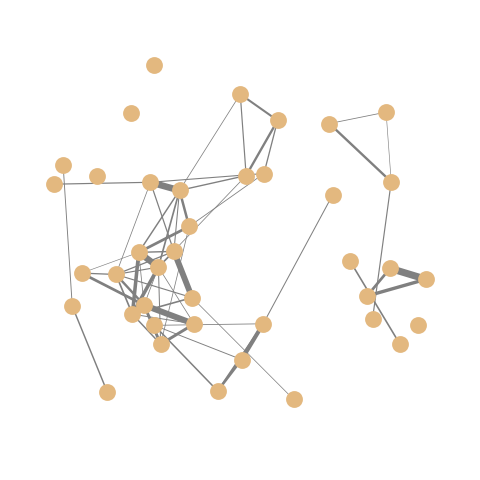

In [6]:
import MDAnalysis as mda
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

u = mda.Universe("./CAHS12-dN/sim_3/protein_shifted.pdb", "./CAHS12-dN/sim_3/protein.xtc")

proteins = [seg.atoms for seg in u.segments]

cutoff = 0.4  # 0.4 nm = 4 Å

u.trajectory[-1]

G = nx.Graph()

for i in range(len(proteins)):
    G.add_node(i)

for i in range(len(proteins)):
    for j in range(i + 1, len(proteins)):
        pos_i = proteins[i].positions
        pos_j = proteins[j].positions
        
        # Check if any pair of atoms are within cutoff distance
        dist_matrix = cdist(pos_i, pos_j)
        if np.any(dist_matrix < cutoff * 10):  # cutoff in Å
            # Compute COM distance
            com_i = proteins[i].center_of_mass()
            com_j = proteins[j].center_of_mass()
            com_dist = np.linalg.norm(com_i - com_j)
            weight = 1.0 / com_dist if com_dist != 0 else 0.0
            G.add_edge(i, j, weight=weight)

weights = [G[u][v]['weight'] * 50 for u, v in G.edges()]  # scaled for better visibility
positions = nx.spring_layout(G, seed=42)

plt.figure(figsize=(3, 3), dpi=150)
nx.draw(
    G, positions,
    with_labels=False,
    node_color='#e3b87f',
    edge_color='gray',
    width=weights,
    node_size=50
)
plt.axis("equal")
plt.tight_layout()
plt.savefig('net-dN.pdf',format='pdf', dpi=400, transparent=True, bbox_inches='tight')
plt.show()


In [7]:
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'


### Statistics

In [1]:
n_clusters = []
cluster_sizes = []
avg_degrees = []

name = 'CAHS12'
directories = ['sim_1', 'sim_2','sim_3']

all_n_clusters = []
all_cluster_sizes = []
all_avg_degrees = []

for folder in directories:
    u = mda.Universe(f"./{name}/{folder}/protein_shifted.pdb", f"./{name}/{folder}/protein.xtc")
    proteins = [seg.atoms for seg in u.segments]
    cutoff = 0.4  # in nm

    n_clusters_rep = []
    cluster_sizes_rep = []
    avg_degrees_rep = []

    for ts in u.trajectory[::5]:
        G = nx.Graph()
        for i in range(len(proteins)):
            G.add_node(i)

        for i in range(len(proteins)):
            for j in range(i + 1, len(proteins)):
                pos_i = proteins[i].positions
                pos_j = proteins[j].positions
                dist_matrix = cdist(pos_i, pos_j)
                if np.any(dist_matrix < cutoff * 10):  # convert to Å
                    com_i = proteins[i].center_of_mass()
                    com_j = proteins[j].center_of_mass()
                    com_dist = np.linalg.norm(com_i - com_j)
                    weight = 1.0 / com_dist if com_dist != 0 else 0.0
                    G.add_edge(i, j, weight=weight)

        # Per-frame stats
        n_cluster = nx.number_connected_components(G)
        components = list(nx.connected_components(G))
        cluster_size = max(len(c) for c in components)
        avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()

        n_clusters_rep.append(n_cluster)
        cluster_sizes_rep.append(cluster_size)
        avg_degrees_rep.append(avg_degree)

    all_n_clusters.append(np.mean(n_clusters_rep))
    all_cluster_sizes.append(np.mean(cluster_sizes_rep))
    all_avg_degrees.append(np.mean(avg_degrees_rep))


NameError: name 'mda' is not defined

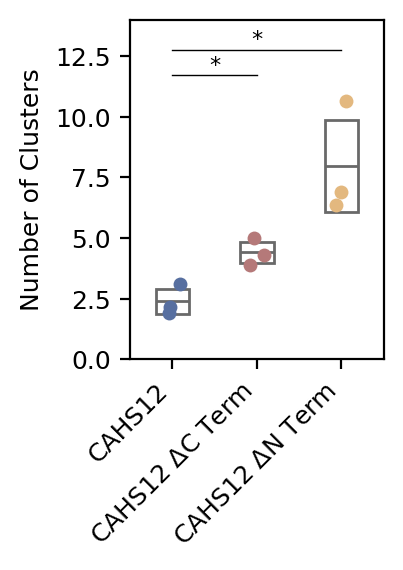

In [9]:
## number of clusters

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.stats import ttest_ind


xnames = ['CAHS12', r'CAHS12 $\Delta$C Term', r'CAHS12 $\Delta$N Term']


data = [
    cluster_full,
    cluster_dc,
    cluster_dn
]

max_val = max(max(row) for row in data)


group1 = data[0]  # CAHS12
group2 = data[1]  # CAHS12-ΔC
group3 = data[2]  # CAHS12-ΔN

tstat_c, pval_c = ttest_ind(group1, group2, equal_var=False)
tstat_n, pval_n = ttest_ind(group1, group3, equal_var=False)

colors = ['#576fa0', '#b57979', '#e3b87f']
xpos = np.arange(1, 4)
size = 25

means = [np.mean(g) for g in data]
stds = [np.std(g) for g in data]

plt.figure(figsize=(2, 3), dpi=200)
ax = plt.gca()
box_width = 0.4

for x, mean, std, color in zip(xpos, means, stds, colors):
    # Box: mean ± std
    rect = patches.Rectangle(
        (x - box_width / 2, mean - std),
        width=box_width,
        height=2 * std,
        edgecolor='dimgray',
        facecolor='white',
        linewidth=1.,
        zorder=2
    )
    ax.add_patch(rect)

    # Mean line inside box
    plt.hlines(mean, x - box_width / 2, x + box_width / 2,
               color='dimgray', linewidth=1., zorder=3)

# Scatter points
for i, (group, color) in enumerate(zip(data, colors)):
    jittered_x = np.full(len(group), xpos[i]) + np.random.uniform(-0.1, 0.1, len(group))
    plt.scatter(jittered_x, group, facecolor=color, edgecolor=color, s=size, linewidth=0, zorder=4, alpha=1)

    
star_c = pval_to_star(pval_c)
star_n = pval_to_star(pval_n)

x_c = (xpos[0] + xpos[1]) / 2
y_c = max_val*1.1
plt.text(x_c, y_c, star_c, ha='center', va='bottom', fontsize=8)

x_n = (xpos[0] + xpos[2]) / 2
y_n = max_val*1.2
plt.text(x_n, y_n, star_n, ha='center', va='bottom', fontsize=8)
plt.plot([xpos[0], xpos[1]], [y_c, y_c], color='black', linewidth=0.5)
plt.plot([xpos[0], xpos[2]], [y_n, y_n], color='black', linewidth=0.5)

# Axes
plt.xticks(xpos, xnames, fontsize=9, rotation=45, ha='right')
plt.ylabel(r'Number of Clusters', fontsize=9)
plt.tick_params(labelsize=9)
plt.xlim(0.5, 3.5)
plt.ylim(0., 14)

plt.tight_layout()
plt.savefig('num_cluster.pdf',format='pdf', dpi=400, transparent=True, bbox_inches='tight')

plt.show()


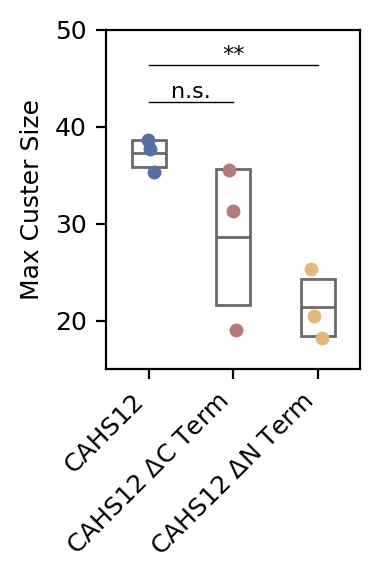

In [10]:
## max cluster size

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.stats import ttest_ind


data = [
    size_full,
    size_dc,
    size_dn
]

max_val = max(max(row) for row in data)


group1 = data[0]  # CAHS12
group2 = data[1]  # CAHS12-ΔC
group3 = data[2]  # CAHS12-ΔN

tstat_c, pval_c = ttest_ind(group1, group2, equal_var=False)
tstat_n, pval_n = ttest_ind(group1, group3, equal_var=False)


xpos = np.arange(1, 4)
size = 25

means = [np.mean(g) for g in data]
stds = [np.std(g) for g in data]

plt.figure(figsize=(2, 3), dpi=200)
ax = plt.gca()
box_width = 0.4

for x, mean, std, color in zip(xpos, means, stds, colors):
    # Box: mean ± std
    rect = patches.Rectangle(
        (x - box_width / 2, mean - std),
        width=box_width,
        height=2 * std,
        edgecolor='dimgray',
        facecolor='white',
        linewidth=1.,
        zorder=2
    )
    ax.add_patch(rect)

    # Mean line inside box
    plt.hlines(mean, x - box_width / 2, x + box_width / 2,
               color='dimgray', linewidth=1., zorder=3)

# Scatter points
for i, (group, color) in enumerate(zip(data, colors)):
    jittered_x = np.full(len(group), xpos[i]) + np.random.uniform(-0.1, 0.1, len(group))
    plt.scatter(jittered_x, group, facecolor=color, edgecolor=color, s=size, linewidth=0, zorder=4, alpha=1)

    
star_c = pval_to_star(pval_c)
star_n = pval_to_star(pval_n)

x_c = (xpos[0] + xpos[1]) / 2
y_c = max_val*1.1
plt.text(x_c, y_c, star_c, ha='center', va='bottom', fontsize=8)

x_n = (xpos[0] + xpos[2]) / 2
y_n = max_val*1.2
plt.text(x_n, y_n, star_n, ha='center', va='bottom', fontsize=8)
plt.plot([xpos[0], xpos[1]], [y_c, y_c], color='black', linewidth=0.5)
plt.plot([xpos[0], xpos[2]], [y_n, y_n], color='black', linewidth=0.5)

# Axes
plt.xticks(xpos, xnames, fontsize=9, rotation=45, ha='right')
plt.ylabel(r'Max Custer Size', fontsize=9)
plt.tick_params(labelsize=9)
plt.xlim(0.5, 3.5)
plt.ylim(15, 50)
plt.tight_layout()
plt.savefig('max_cluster.pdf',format='pdf', dpi=400, transparent=True, bbox_inches='tight')
plt.show()


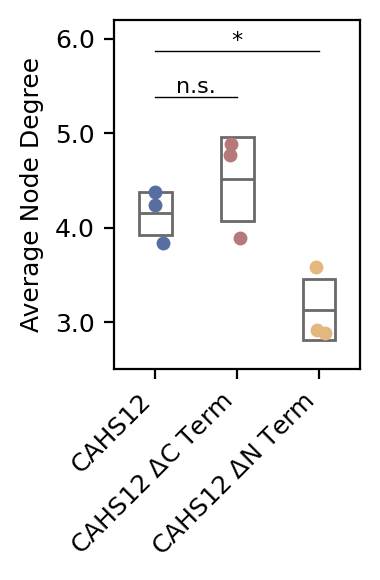

In [11]:
## ave degree

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.stats import ttest_ind


data = [
    degree_full,
    degree_dc,
    degree_dn
]

max_val = max(max(row) for row in data)

group1 = data[0]  # CAHS12
group2 = data[1]  # CAHS12-ΔC
group3 = data[2]  # CAHS12-ΔN

tstat_c, pval_c = ttest_ind(group1, group2, equal_var=False)
tstat_n, pval_n = ttest_ind(group1, group3, equal_var=False)


xpos = np.arange(1, 4)
size = 25

means = [np.mean(g) for g in data]
stds = [np.std(g) for g in data]

plt.figure(figsize=(2, 3), dpi=200)
ax = plt.gca()
box_width = 0.4

for x, mean, std, color in zip(xpos, means, stds, colors):
    # Box: mean ± std
    rect = patches.Rectangle(
        (x - box_width / 2, mean - std),
        width=box_width,
        height=2 * std,
        edgecolor='dimgray',
        facecolor='white',
        linewidth=1.,
        zorder=2
    )
    ax.add_patch(rect)

    # Mean line inside box
    plt.hlines(mean, x - box_width / 2, x + box_width / 2,
               color='dimgray', linewidth=1., zorder=3)

# Scatter points
for i, (group, color) in enumerate(zip(data, colors)):
    jittered_x = np.full(len(group), xpos[i]) + np.random.uniform(-0.1, 0.1, len(group))
    plt.scatter(jittered_x, group, facecolor=color, edgecolor=color, s=size, linewidth=0, zorder=4, alpha=1)


    
star_c = pval_to_star(pval_c)
star_n = pval_to_star(pval_n)

x_c = (xpos[0] + xpos[1]) / 2
y_c = max_val*1.1
plt.text(x_c, y_c, star_c, ha='center', va='bottom', fontsize=8)

x_n = (xpos[0] + xpos[2]) / 2
y_n = max_val*1.2
plt.text(x_n, y_n, star_n, ha='center', va='bottom', fontsize=8)
plt.plot([xpos[0], xpos[1]], [y_c, y_c], color='black', linewidth=0.5)
plt.plot([xpos[0], xpos[2]], [y_n, y_n], color='black', linewidth=0.5)

# Axes
plt.xticks(xpos, xnames, fontsize=9, rotation=45, ha='right')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))

plt.xticks(xpos, xnames, fontsize=9, rotation=45, ha='right')
plt.ylabel(r'Average Node Degree', fontsize=9)
plt.tick_params(labelsize=9)

plt.xlim(0.5, 3.5)
plt.ylim(2.5, 6.2)
plt.tight_layout()
plt.savefig('node_degree.pdf',format='pdf', dpi=400, transparent=True, bbox_inches='tight')
plt.show()
